<a href="https://colab.research.google.com/github/thekaranacharya/tweet-sentiment-detection/blob/master/comparative-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Twitter Sentiment Analysis - A comparative study of LSTMs, GRUs & Conv1D layers in TensorFlow-Keras**

In [12]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 160000

corpus = []

In [2]:
import os

# downloading the cleaned dataset from Laurence Moroney's site
dataset_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv"
fname = os.path.join(os.getcwd(), "twitter-data.csv")
tf.keras.utils.get_file(fname, origin=dataset_url, extract=True)

238944256/238942690 [==============================] - 2s 0us/step


'/content/twitter-data.csv'

In [13]:
num_sentences = 0
with open('/content/twitter-data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    list_item = []
    list_item.append(row[-1])
    label = 0 if row[0] == '0' else 1
    list_item.append(label)
    num_sentences += 1
    corpus.append(list_item)


print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [14]:
# Splitting the data 80-10-10
sentences = []
labels = []
random.shuffle(corpus)

for x in range(training_size):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

training_portion = 0.8
val_limit = 0.9

train_split = int(training_portion * len(sentences))
val_split = int(val_limit * len(sentences))


training_sentences = sentences[: train_split]
training_labels = labels[: train_split]

val_sentences = sentences[train_split: val_split]
val_labels = labels[train_split: val_split]

test_sentences = sentences[val_split:]
test_labels = labels[val_split:]

print(len(sentences), len(labels))
print(len(training_sentences), len(training_labels))
print(len(val_sentences), len(val_labels))
print(len(test_sentences), len(test_labels))

160000 160000
128000 128000
16000 16000
16000 16000


In [15]:
# Defining the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(word_index, "\n", vocab_size)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(training_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5, 'and': 6, 'you': 7, 'is': 8, 'it': 9, 'in': 10, 'for': 11, 'of': 12, 'on': 13, 'me': 14, 'so': 15, 'have': 16, 'that': 17, 'but': 18, "i'm": 19, 'just': 20, 'with': 21, 'at': 22, 'be': 23, 'not': 24, 'was': 25, 'this': 26, 'now': 27, 'up': 28, 'good': 29, 'day': 30, 'all': 31, 'out': 32, 'get': 33, 'like': 34, 'no': 35, 'are': 36, 'quot': 37, 'go': 38, 'http': 39, 'do': 40, 'today': 41, "it's": 42, 'too': 43, 'your': 44, 'work': 45, 'going': 46, 'love': 47, 'got': 48, 'lol': 49, 'from': 50, 'time': 51, 'back': 52, 'one': 53, 'what': 54, 'u': 55, 'im': 56, 'we': 57, 'com': 58, 'know': 59, 'will': 60, 'about': 61, 'really': 62, 'am': 63, 'amp': 64, "don't": 65, 'can': 66, 'had': 67, 'see': 68, "can't": 69, 'its': 70, 'some': 71, 'if': 72, 'want': 73, 'still': 74, 'night': 75, '2': 76, 'new': 77, 'think': 78, 'well': 79, 'home': 80, 'how': 81, 'thanks': 82, 'oh': 83, 'when': 84, 'as': 85, 'more': 86, 'there': 87, 'miss': 88, 'much': 89, 'off': 

In [16]:
# Using GloVe Embeddings (Transfer Learning)

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

print(len(embeddings_matrix))

--2020-09-10 06:16:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   190MB/s    in 1.7s    

2020-09-10 06:16:38 (190 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

118500


**Model 0 : Only the Embedding layer**

In [17]:
training_labels = np.array(training_labels)
val_labels = np.array(val_labels)

model_0 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length, 
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           11850000  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 11,850,817
Trainable params: 817
Non-trainable params: 11,850,000
_________________________________________________________________


In [18]:
history_0 = model_0.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/50
4000/4000 - 10s - loss: 0.6156 - accuracy: 0.6671 - val_loss: 0.5935 - val_accuracy: 0.6891
Epoch 2/50
4000/4000 - 10s - loss: 0.5902 - accuracy: 0.6886 - val_loss: 0.5855 - val_accuracy: 0.6913
Epoch 3/50
4000/4000 - 10s - loss: 0.5835 - accuracy: 0.6918 - val_loss: 0.5818 - val_accuracy: 0.6946
Epoch 4/50
4000/4000 - 10s - loss: 0.5796 - accuracy: 0.6927 - val_loss: 0.5780 - val_accuracy: 0.6964
Epoch 5/50
4000/4000 - 10s - loss: 0.5774 - accuracy: 0.6941 - val_loss: 0.5747 - val_accuracy: 0.6994
Epoch 6/50
4000/4000 - 10s - loss: 0.5757 - accuracy: 0.6959 - val_loss: 0.5726 - val_accuracy: 0.7003
Epoch 7/50
4000/4000 - 10s - loss: 0.5744 - accuracy: 0.6970 - val_loss: 0.5771 - val_accuracy: 0.6935
Epoch 8/50
4000/4000 - 10s - loss: 0.5734 - accuracy: 0.6970 - val_loss: 0.5742 - val_accuracy: 0.6973
Epoch 9/50
4000/4000 - 10s - loss: 0.5725 - accuracy: 0.6985 - val_loss: 0.5745 - val_accuracy: 0.6959
Epoch 10/50
4000/4000 - 10s - loss: 0.5718 - accuracy: 0.6996 - val_loss:

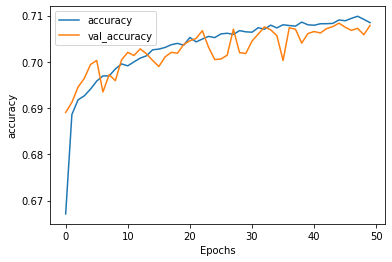

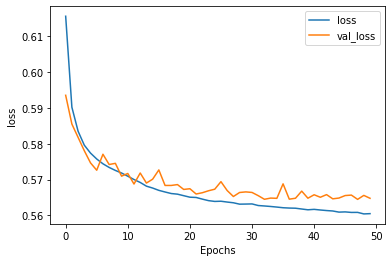

In [19]:
import matplotlib.pyplot as plt
def plot_graphs(hist, string):
    plt.plot(hist.history[string])
    plt.plot(hist.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history_0, "accuracy")
plot_graphs(history_0, "loss")

**Model 1 : Embedding with 1 (unidirectional) LSTM**


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 100)           11850000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 11,892,769
Trainable params: 42,769
Non-trainable params: 11,850,000
_________________________________________________________________
Epoch 1/50
4000/4000 - 24s - loss: 0.5442 - accuracy: 0.7194 - val_loss: 0.5078 - val_accuracy: 0.7469
Epoch 2/50
4000/4000 - 24s - loss: 0.4956 - accuracy: 0.7583 - val_loss: 0.4888 - val_accuracy: 0.7619
Epoch 3/50
4000/4000 - 24s - 

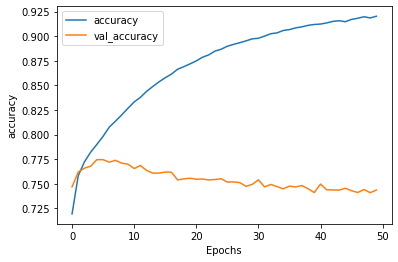

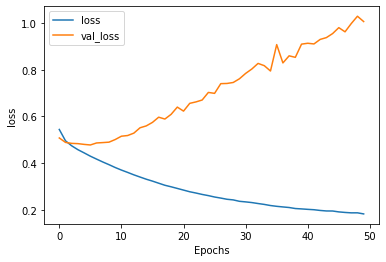

In [20]:
model_1 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

history_1 = model_1.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

**Model 2 : Embedding with 1 Bidirectional LSTM**

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 100)           11850000  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 11,935,521
Trainable params: 85,521
Non-trainable params: 11,850,000
_________________________________________________________________
Epoch 1/50
4000/4000 - 44s - loss: 0.5383 - accuracy: 0.7227 - val_loss: 0.5038 - val_accuracy: 0.7486
Epoch 2/50
4000/4000 - 44s - loss: 0.4868 - accuracy: 0.7625 - val_loss: 0.4835 - val_accuracy: 0.7651
Epoch 3/50
4000/4000 - 44s - 

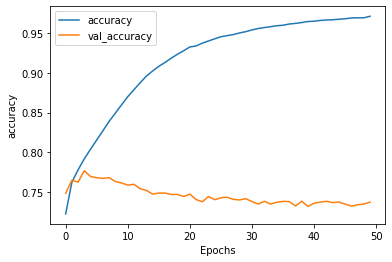

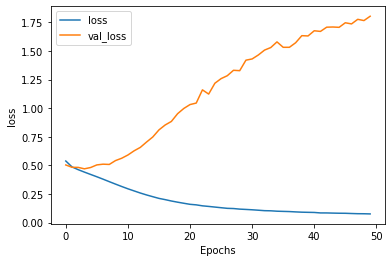

In [21]:
model_2 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

history_2 = model_2.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

**Model 3 : Embedding with Dropout & 2 Bidirectional LSTMs**

In [ ]:
model_3 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Dropout(0.2),                         
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.summary()

history_3 = model_3.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 16, 100)           11850000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 12,033,425
Trainable params: 183,425
Non-trainable params: 11,850,000
_________________________________________________________________
Epoch 1/50
4000/4000 - 83s - loss: 0.5537 - accuracy: 0.7140 - val_loss: 0.5235 - val_accuracy: 0.7332

**Model 4 : Embedding with 1 (unidirectional) GRU**

In [ ]:
model_4 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.GRU(64),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_4.summary()

history_4 = model_4.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_4, "accuracy")
plot_graphs(history_4, "loss")

**Model 5 : Embedding with 1 Bidirectional GRU**

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 16, 100)           11850000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               63744     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 11,914,785
Trainable params: 64,785
Non-trainable params: 11,850,000
_________________________________________________________________
Epoch 1/50
4000/4000 - 46s - loss: 0.5341 - accuracy: 0.7267 - val_loss: 0.4975 - val_accuracy: 0.7571
Epoch 2/50
4000/4000 - 45s - loss: 0.4833 - accuracy: 0.7649 - val_loss: 0.4878 - val_accuracy: 0.7655
Epoch 3/50
4000/4000 - 45s - 

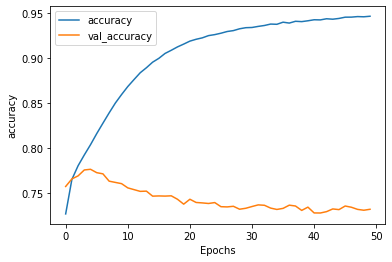

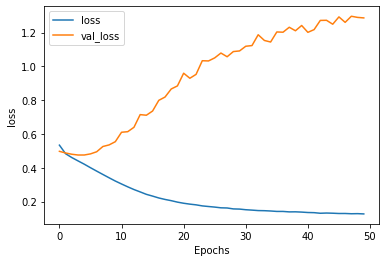

In [24]:
model_5 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_5.summary()

history_5 = model_5.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_5, "accuracy")
plot_graphs(history_5, "loss")

**Model 6 : Embedding with 2 Bidirectional GRUs**

In [ ]:
model_6 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, num_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_6.summary()

history_6 = model_6.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_6, "accuracy")
plot_graphs(history_6, "loss")

**Model 7 : Embedding with 1 Conv1D and 1 MaxPooling1D layer**

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 16, 100)           11850000  
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 128)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 3, 8)              1032      
_________________________________________________________________
dense_11 (Dense)             (None, 3, 1)              9         
Total params: 11,915,169
Trainable params: 65,169
Non-trainable params: 11,850,000
_________________________________________________________________
Epoch 1/50
4000/4000 [==============================] - 15s 4ms/step - loss: 0.6260 - accuracy: 0.6363 

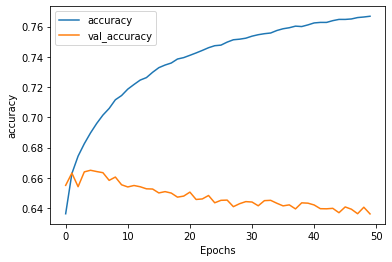

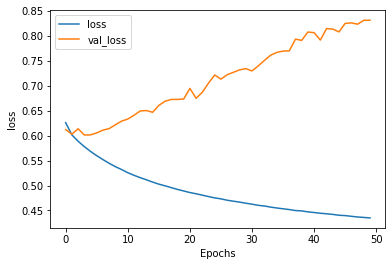

In [22]:
model_7 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Conv1D(128, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=4),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_7.summary()

history_7 = model_7.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_7, "accuracy")
plot_graphs(history_7, "loss")

**Model 8: Embedding with 1 set of Conv1D & MaxPooling1D with 1 Bidirectional LSTM**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 16, 100)           11850000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 128)           64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 12,013,985
Trainable params: 163,985
Non-trainable params: 11,850,000
____________________________________

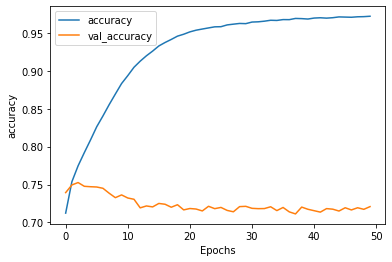

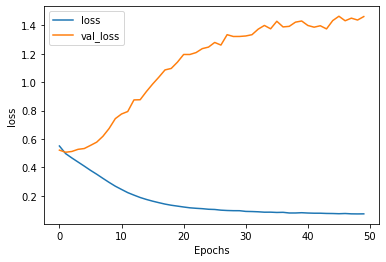

In [23]:
model_8 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Conv1D(128, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=4),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_8.summary()

history_8 = model_8.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_8, "accuracy")
plot_graphs(history_8, "loss")

**Model 9: Embedding with Dropout, Conv1D, MaxPooling1D, 1 Bidirectional LSTM**

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 16, 100)           11850000  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

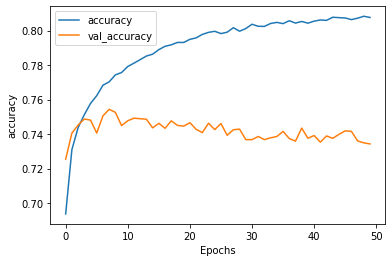

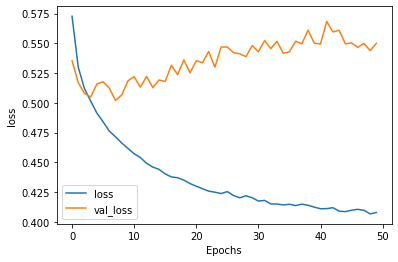

In [25]:
model_9 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Dropout(0.2),                         
      tf.keras.layers.Conv1D(64, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=4),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_9.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_9.summary()

history_9 = model_9.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_9, "accuracy")
plot_graphs(history_9, "loss")